# Movie Embedding and Similarity Search
## This notebook demonstrates how to generate embeddings for a set of movies using the MiniLM model and then find similar movies based on cosine similarity.

In [20]:
!pip install transformers psycopg2-binary numpy torch scikit-learn matplotlib nltk sentence-transformers pandas pgvector tiktoken huggingface_hub gradio tqdm rich ipywidgets rank_bm25

Defaulting to user installation because normal site-packages is not writeable


In [21]:
import json
import os

import numpy as np

# Database
import psycopg2

# Plotting
import matplotlib.pyplot as plt

# NLP
import nltk # natural language toolkit
from nltk.corpus import stopwords # stopwords

# Sentence transformers
import torch
from transformers import AutoTokenizer, AutoModel # Huggingface transformers
import torch.nn.functional as F

# Vector similarity
from sklearn.metrics.pairwise import cosine_similarity # cosine similarity

# Console output
from tqdm import tqdm # progress bar
from rich.console import Console # rich text

import gradio as gr # UI

console = Console()
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\antoi\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

# Define AI model

In [22]:
models = {
    "MiniLM": { # https://huggingface.co/sentence-transformers/all-MiniLM-L6-v2
        "model_name": 'sentence-transformers/all-MiniLM-L6-v2',
        "tokenizer": AutoTokenizer.from_pretrained('sentence-transformers/all-MiniLM-L6-v2'),
        "model": AutoModel.from_pretrained('sentence-transformers/all-MiniLM-L6-v2')
    },
}

## Load Movie Data

In [23]:
def load_movies_data(file_path):
    with open(file_path, "r", encoding="utf-8") as f:
        movies = json.load(f)
    return movies["films"]["film"]

In [24]:
def preprocess_movie_data(movies):
    movies_data = []
    for movie in movies:
        roles = movie.get("role", [])
        if isinstance(roles, dict):
            roles = [roles]
        actors = [role.get("acteur", {}).get("__text", "") for role in roles]
        movies_data.append({
            "title": movie.get("titre", ""),
            "year": movie.get("annee", ""),
            "country": movie.get("pays", ""),
            "language": movie.get("langue", ""),
            "duration": movie.get("duree", ""),
            "summary": movie.get("synopsis", ""),
            "genre": movie.get("genre", ""),
            "director": movie.get("realisateur", {"__text": ""}).get("__text", ""),
            "writers": movie.get("scenariste", []),
            "actors": actors,
            "poster": movie.get("poster", ""),
            "id": movie.get("id", "")
        })
    return movies_data

# Preprocess
Remove stopword and bad character

In [25]:
def preprocess_text(text):
    tokens = text.split()
    stopwords_set = set(stopwords.words('english'))
    tokens = [word for word in tokens if word.lower() not in stopwords_set]
    return ' '.join(tokens)

# Normalize Data

Make a better distribution of the result

In [26]:
def mean_pooling(model_output, attention_mask):
    token_embeddings = model_output[0]  # First element of model_output contains all token embeddings
    input_mask_expanded = attention_mask.unsqueeze(-1).expand(token_embeddings.size()).float()
    return torch.sum(token_embeddings * input_mask_expanded, 1) / torch.clamp(input_mask_expanded.sum(1), min=1e-9)

# Generate embedding

Make sure to chose the right attribute to add to the vector

In [27]:
def generate_embedding(movies_data, model_key, normalize=True):
    model_config = models[model_key]
    tokenizer = model_config['tokenizer']
    model = model_config['model']

    movie_texts = [
        f"{preprocess_text(movie['title'])} {movie['year']} {' '.join(movie['genre'])} "
        f"{' '.join(movie['actors'])} {movie['director']} "
        f"{preprocess_text(movie['summary'])} {movie['country']} {movie['language']} {' '.join(movie['writers'])}"
        for movie in tqdm(movies_data, desc="Creating movie texts")
    ]

    # Tokenize the texts
    encoded_input = tokenizer(movie_texts, padding=True, truncation=True, max_length=512, return_tensors='pt')

    # Compute token embeddings
    with torch.no_grad():
        model_output = model(**encoded_input)

    # Perform pooling
    sentence_embeddings = mean_pooling(model_output, encoded_input['attention_mask'])

    # Normalize the embeddings
    if normalize:
        sentence_embeddings = F.normalize(sentence_embeddings, p=2, dim=1)

    return sentence_embeddings.numpy()

# Setup connection with database

Use prisma or other simple example here

In [28]:
def setup_database(conn, cur):
    # Enable required extensions
    cur.execute("CREATE EXTENSION IF NOT EXISTS vector;")
    cur.execute("CREATE EXTENSION IF NOT EXISTS cube;")
    cur.execute("CREATE EXTENSION IF NOT EXISTS pg_trgm;")
    conn.commit()

    # Create the movies table
    cur.execute('DROP TABLE IF EXISTS movies') # Drop the table if it already exists
    cur.execute('''
        CREATE TABLE movies (
            id SERIAL PRIMARY KEY,
            title TEXT NOT NULL,
            actors TEXT,
            year INTEGER,
            country TEXT,
            language TEXT,
            duration INTEGER,
            summary TEXT,
            genre TEXT[],
            director TEXT,
            scenarists TEXT[],
            poster TEXT,
            embedding_MiniLM VECTOR(384)
        );
    ''')
    conn.commit()

# Insert movie
Add embbbeding in the database

Threading to increase speed

In [29]:
def insert_movie(cur, movie, emb):
    actor_names = ', '.join(movie['actors'])
    genre_array = '{' + ', '.join([f'"{g}"' for g in movie['genre']]) + '}'
    scenarist_array = '{' + ', '.join([f'"{s}"' for s in movie['writers']]) + '}'
    embedding_str = '[' + ', '.join(map(str, emb)) + ']' # Convert the embedding to a string

    cur.execute('''
        INSERT INTO movies (title, actors, year, country, language, duration, summary, genre, director, scenarists, poster, embedding_MiniLM)
        VALUES (%s, %s, %s, %s, %s, %s, %s, %s, %s, %s, %s, %s)
    ''', (
        movie['title'], actor_names, movie['year'], movie['country'], movie['language'],
        movie['duration'], movie['summary'], genre_array, movie['director'],
        scenarist_array, movie['poster'], embedding_str
    ))

def insert_movies(conn, cur, movies_data, embeddings):
    for movie, emb in tqdm(zip(movies_data, embeddings), desc="Inserting movies into database"):
        insert_movie(cur, movie, emb)
    conn.commit()


# Best matching title
using pg_trgm

In [30]:
def get_best_matching_title(cur, title, threshold=0.3):
    cur.execute("""
        SELECT title
        FROM movies
        ORDER BY similarity(title, %s) DESC
        LIMIT 1
    """, (title,))
    result = cur.fetchone()
    if result and result[0]:
        cur.execute("""
            SELECT similarity(%s, %s)
        """, (result[0], title))
        similarity_score = cur.fetchone()[0]
        if similarity_score >= threshold:
            return result[0]
    return None

## Find similar movies

Get the embebbing in the database

In [31]:
def get_query_embedding(conn, cur, title):
    best_title = get_best_matching_title(cur, title)
    if not best_title:
        console.print(f"[red]No close match found for the movie titled '{title}'.[/red]")
        return None

    try:
        cur.execute("SELECT embedding_MiniLM FROM movies WHERE title = %s", (best_title,))
        if result := cur.fetchone():
            embedding_str = result[0]
            embedding = [float(x) for x in embedding_str.strip('[]').split(',')]
            return np.array(embedding, dtype=float).reshape(1, -1)
    except Exception as e:
        console.print(f"[red]Error querying embedding for title '{title}': {e}[/red]")
        conn.rollback()
    return None

# Find similar movie for one title

Compare the search query with the database resulth using cosine similitide with pgvector or python

In [32]:
def find_similar_movies(conn, cur, title, threshold=0.5, return_n=10):
    query_embedding = get_query_embedding(conn, cur, title)
    if query_embedding is None:
        console.print(f"[red]No embedding found for the movie titled '{title}'.[/red]")
        return []

    cur.execute('SELECT title, year, poster, embedding_MiniLM FROM movies')
    rows = cur.fetchall()

    embeddings = []
    movie_details = []
    for other_title, year, poster, embedding_str in rows:
        if other_title != title:
            embedding = np.array([float(x) for x in embedding_str.strip('[]').split(',')])
            embeddings.append(embedding)
            movie_details.append((other_title, year, poster))

    distances = cosine_similarity(query_embedding, embeddings)
    similar_movies = [(movie_details[i][0], movie_details[i][1], movie_details[i][2], distances[0][i]) for i in range(len(movie_details)) if distances[0][i] > threshold]
    similar_movies.sort(key=lambda x: x[3], reverse=True)
    return similar_movies[:return_n]

# Find similiar movies with a list of title

In [33]:
def get_query_embeddings_list(conn, cur, titles):
    embeddings = [
        get_query_embedding(conn, cur, title)
        for title in titles
    ]
    # Calculate the mean embedding
    mean_embedding = np.mean(embeddings, axis=0)
    return mean_embedding

In [34]:
def find_similar_movies_list(conn, cur, titles, threshold=0.5, return_n=10):
    query_embedding = get_query_embeddings_list(conn, cur, titles)
    if query_embedding is None:
        console.print(f"[red]No embeddings found for the given movie titles: {', '.join(titles)}[/red]")
        return []

    cur.execute('SELECT title, year, poster, embedding_MiniLM FROM movies')
    rows = cur.fetchall()

    embeddings = []
    movie_details = []
    for other_title, year, poster, embedding_str in rows:
        if other_title not in titles:
            embedding = np.array([float(x) for x in embedding_str.strip('[]').split(',')])
            embeddings.append(embedding)
            movie_details.append((other_title, year, poster))

    distances = cosine_similarity(query_embedding, embeddings)
    similar_movies = [(movie_details[i][0], movie_details[i][1], movie_details[i][2], distances[0][i]) for i in range(len(movie_details)) if distances[0][i] > threshold]
    similar_movies.sort(key=lambda x: x[3], reverse=True)
    return similar_movies[:return_n]

# Find similiar movies with a list of title and rating to make ponderation of vector

In [35]:
def find_similar_movies_ratings(conn, cur, titles, ratings, influential_index=0, influence_factor=2, threshold=0.5, return_n=10):
    embeddings = []

    for title in titles:
        query_embedding = get_query_embedding(conn, cur, title)
        if query_embedding is None:
            console.print(f"[red]No embedding found for the movie titled '{title}'.[/red]")
            return []

        embeddings.append(query_embedding)

    # higher ratings are more influential
    # lower ratings are less influential
    weights = [
        (ratings[i] - 1) * influence_factor if i == influential_index else ratings[i]
        for i in range(len(ratings))
    ]

    # Compute weighted average embedding
    query_embedding = np.average(embeddings, axis=0, weights=weights)

    cur.execute('SELECT title, year, poster, embedding_MiniLM FROM movies')
    rows = cur.fetchall()

    embeddings = []
    movie_details = []
    for other_title, year, poster, embedding_str in rows:
        if other_title not in titles:
            embedding = np.array([float(x) for x in embedding_str.strip('[]').split(',')])
            embeddings.append(embedding)
            movie_details.append((other_title, year, poster))

    distances = cosine_similarity(query_embedding, embeddings)
    similar_movies = [(movie_details[i][0], movie_details[i][1], movie_details[i][2], distances[0][i]) for i in range(len(movie_details)) if distances[0][i] > threshold]
    similar_movies.sort(key=lambda x: x[3], reverse=True)
    return similar_movies[:return_n]

## Plot similar movies

helper function to make plot

In [36]:
def plot_similar_movies(similar_movies, query_movie_title):
    similar_movies = [(title, similarity) for title, _, _, similarity in similar_movies]
    titles = [title for title, _ in similar_movies]
    similarities = [round(sim * 100, 3) for _, sim in similar_movies]


    fig, ax = plt.subplots(figsize=(14, 8))

    bars = ax.bar(titles, similarities, color='skyblue')
    ax.set_ylabel('Similarity Score (%)')
    ax.set_title(f"Similar Movies for '{query_movie_title}'")
    ax.set_xticks(range(len(titles)))
    ax.set_xticklabels(titles, rotation=90, ha='right', fontsize=10)
    ax.grid(True, which='both', linestyle='--', linewidth=0.5)

    plt.tight_layout(pad=2)
    plt.show()

# Main

Run the script

In [37]:
def main():
    current_directory = os.getcwd()
    movies_file_path = os.path.join(current_directory, "movies.json")

    console.print("[green]Loading movies data...[/green]")
    movies = load_movies_data(movies_file_path)
    movies_data = preprocess_movie_data(movies)
    console.print("[green]Generating embeddings...[/green]")
    embeddings_MiniLM = generate_embedding(movies_data, 'MiniLM')
    embeddings_MiniLM = np.array(embeddings_MiniLM)

    conn = psycopg2.connect(database="postgres", host="localhost", user="postgres", password="postgres", port="5432")
    cur = conn.cursor()

    setup_database(conn, cur)
    console.print("[green]Inserting movies into the database...[/green]")
    insert_movies(conn, cur, movies_data, embeddings_MiniLM)
    console.print("[green]Done![/green]")

    return conn, cur

In [38]:
conn, cur = main()

Loading movies data...

Generating embeddings...

Creating movie texts: 100%|██████████| 631/631 [00:00<00:00, 1255.68it/s]


Inserting movies into the database...

Inserting movies into database: 631it [00:01, 336.11it/s]


Done!

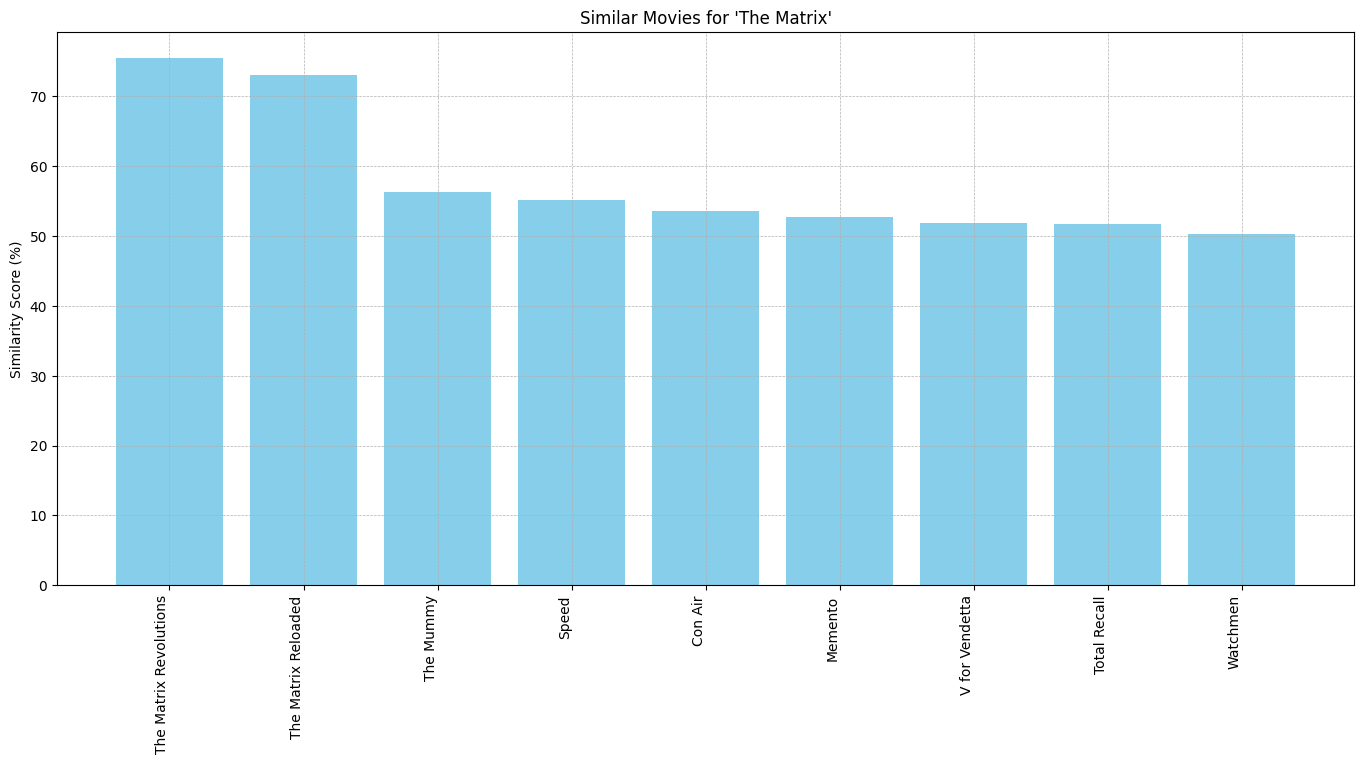

In [39]:
title = "The Matrix"
similar_movies = find_similar_movies(conn, cur, title)
plot_similar_movies(similar_movies, title)

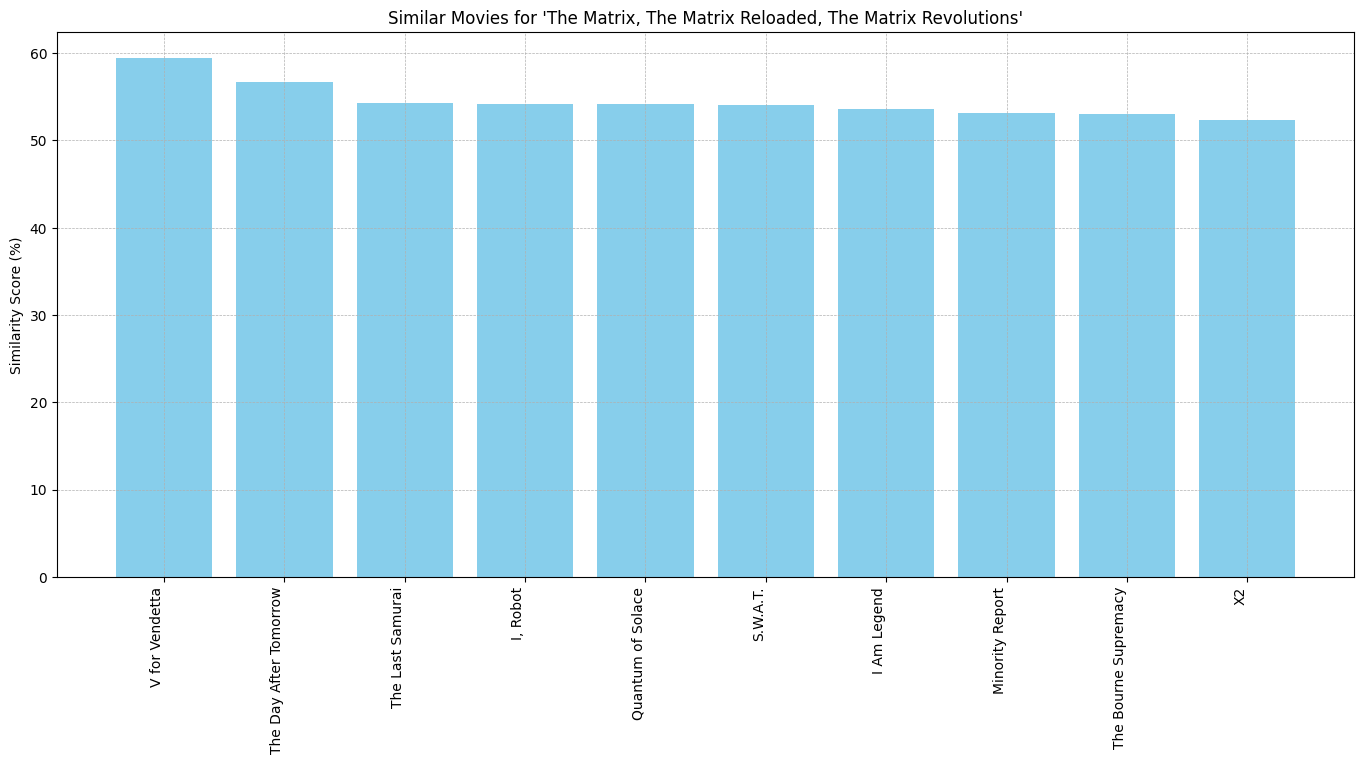

In [40]:
titles = ["The Matrix", "The Matrix Reloaded", "The Matrix Revolutions"]
similar_movies = find_similar_movies_list(conn, cur, titles)
plot_similar_movies(similar_movies, ', '.join(titles))

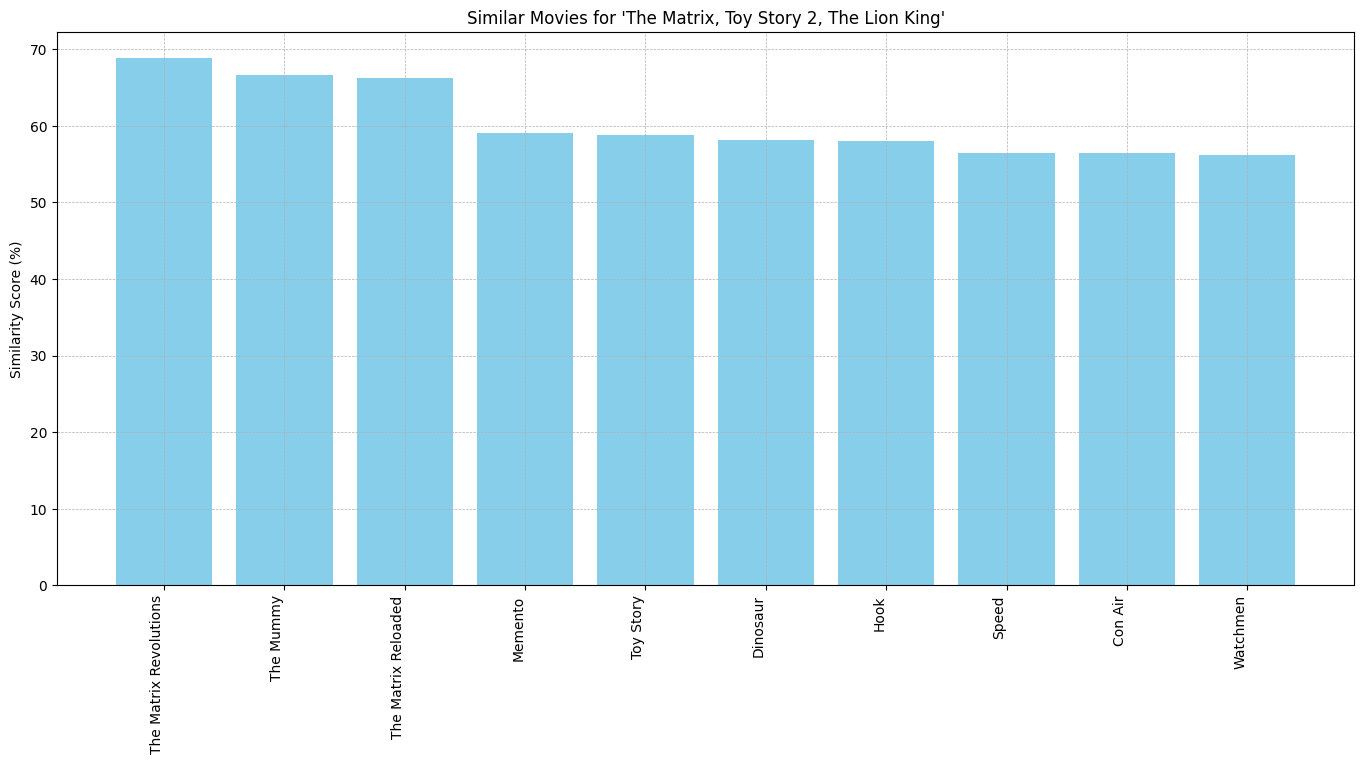

In [41]:
titles = ["The Matrix", "Toy Story 2", "The Lion King"]
ratings = [100, 100, 1]
similar_movies = find_similar_movies_ratings(conn, cur, titles, ratings)
plot_similar_movies(similar_movies, ', '.join(titles))

# Gradio UI

In [42]:
def update_inputs(search_type):
    if search_type == "Single":
        return gr.update(visible=True), gr.update(visible=False)
    elif search_type == "Multiple":
        return gr.update(visible=True), gr.update(visible=False)
    elif search_type == "Ratings":
        return gr.update(visible=True), gr.update(visible=True)
    else:
        return gr.update(visible=False), gr.update(visible=False)

In [43]:
def gradio_interface(search_type, movie_titles, movie_ratings):
    if search_type == "Single":
        similar_movies = find_similar_movies(conn, cur, movie_titles)
        if not similar_movies:
            return "No similar movies found."
        result = f"<h3>Similar Movies to '{movie_titles}'</h3>"
    elif search_type == "Multiple":
        titles = [title.strip() for title in movie_titles.split(',')]
        similar_movies = find_similar_movies_list(conn, cur, titles)
        if not similar_movies:
            return "No similar movies found."
        result = f"<h3>Similar Movies to '{', '.join(titles)}'</h3>"
    elif search_type == "Ratings":
        titles = [title.strip() for title in movie_titles.split(',')]
        ratings = [int(rating) for rating in movie_ratings.split(',')]
        similar_movies = find_similar_movies_ratings(conn, cur, titles, ratings)
        if not similar_movies:
            return "No similar movies found."
        result = f"<h3>Similar Movies to '{', '.join(titles)}' with ratings {', '.join(map(str, ratings))}</h3>"
    else:
        return "Invalid search type."

    result += "<table border='1' style='width:100%'><tr><th>Poster</th><th>Title</th><th>Year</th><th>Similarity (%)</th></tr>"
    for title, year, poster, similarity in similar_movies:
        result += f"<tr><td><img src='{poster}' alt='{title} poster' style='width:50px;height:auto;'></td><td>{title}</td><td>{year}</td><td>{similarity*100:.2f}</td></tr>"
    result += "</table>"

    return result

with gr.Blocks() as demo:
    search_type = gr.Radio(["Single", "Multiple", "Ratings"], label="Search Type")
    movie_titles = gr.Textbox(lines=2, placeholder="Enter movie title(s) separated by commas", visible=True)
    movie_ratings = gr.Textbox(lines=2, placeholder="Enter ratings separated by commas (only for Ratings search)", visible=False)

    search_type.change(fn=update_inputs, inputs=[search_type], outputs=[movie_titles, movie_ratings])

    interface = gr.Interface(fn=gradio_interface, inputs=[search_type, movie_titles, movie_ratings], outputs=gr.HTML(), title="Movie Similarity Search")

    demo.launch(share=True)

Running on local URL:  http://127.0.0.1:7860
Running on public URL: https://bff95caa041b6bf36e.gradio.live

This share link expires in 72 hours. For free permanent hosting and GPU upgrades, run `gradio deploy` from Terminal to deploy to Spaces (https://huggingface.co/spaces)
